# **Movie Analysis Notebook**

In [119]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
import math
import sqlite3
import zipfile
import warnings
warnings.filterwarnings('ignore')

In [120]:
movie = pd.read_csv('../data/zippedData/tmdb.movies.csv.gz')
movie_info = pd.read_csv('../data/zippedData/rt.movie_info.tsv.gz',sep='\t', compression='gzip')
movie_review = pd.read_csv('../data/zippedData/rt.reviews.tsv.gz', sep='\t', encoding='latin1')
movie_gross = pd.read_csv('../data/zippedData/bom.movie_gross.csv.gz')
movie_budget = pd.read_csv('../data/zippedData/tn.movie_budgets.csv.gz')
conn = sqlite3.connect('../data/zippedData/im.db.zip')

In [121]:
#specify the path to the zip file
zip_file_path = '../data/zippedData/im.db.zip'

#Extract the SQLite database file from the zip file
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall('../unzippedData')

#connect to extracted SQLite database
database_path = '../unzippedData/im.db'
conn = sqlite3.connect(database_path)

## **Exploratory Data Analysis (EDA)**

### **Movie DF EDA**

In [122]:
# drop the 'Unnamed: 0' column from the movie dataframe
movie.drop('Unnamed: 0', axis=1, inplace=True)

In [123]:
# convert release_date to datetime and filter for movies
movie['release_date'] = pd.to_datetime(movie['release_date'])

# create a new column called release month that takes the month from release_date
movie['release_month'] = movie['release_date'].dt.month

# create a column called release_year and take just the year from release_date
movie['release_year'] = pd.to_datetime(movie['release_date']).dt.year

# drop the release_date column
movie.drop('release_date', axis=1, inplace=True)

### **Movie_Budget EDA**

In [124]:
# convert release_date to datetime format
movie_budget['release_date'] = pd.to_datetime(movie_budget['release_date'])

# create new columns release_year and release_month
movie_budget['release_year'] = movie_budget['release_date'].dt.year
movie_budget['release_month'] = movie_budget['release_date'].dt.month

# drop release_date column from movie_budget dataframe
movie_budget.drop('release_date', axis=1, inplace=True)

# convert production_budget, domestic_gross, and worldwide_gross to numerical values
movie_budget['production_budget'] = pd.to_numeric(movie_budget['production_budget'].str.replace('$','').str.replace(',',''), errors='coerce')
movie_budget['domestic_gross'] = pd.to_numeric(movie_budget['domestic_gross'].str.replace('$','').str.replace(',',''), errors='coerce')
movie_budget['worldwide_gross'] = pd.to_numeric(movie_budget['worldwide_gross'].str.replace('$','').str.replace(',',''), errors='coerce')

### **Merging Movie and Movie_Budget**

In [125]:
# merge movie_budget and movie dataframes using 'movie' and 'title' columns respectively
merged_df = pd.merge(movie_budget, movie, left_on='movie', right_on='title')

In [126]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2385 entries, 0 to 2384
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id_x               2385 non-null   int64  
 1   movie              2385 non-null   object 
 2   production_budget  2385 non-null   int64  
 3   domestic_gross     2385 non-null   int64  
 4   worldwide_gross    2385 non-null   int64  
 5   release_year_x     2385 non-null   int32  
 6   release_month_x    2385 non-null   int32  
 7   genre_ids          2385 non-null   object 
 8   id_y               2385 non-null   int64  
 9   original_language  2385 non-null   object 
 10  original_title     2385 non-null   object 
 11  popularity         2385 non-null   float64
 12  title              2385 non-null   object 
 13  vote_average       2385 non-null   float64
 14  vote_count         2385 non-null   int64  
 15  release_month_y    2385 non-null   int32  
 16  release_year_y     2385 

## **Data Cleaning & Imputation**

In [127]:
merged_df.drop(['id_y', 'original_title', 'title', 'release_year_x', 'release_month_x'], axis=1, inplace=True)

In [128]:
merged_df.rename(columns={'id_x': 'id', 'release_year_y': 'release_year', 'release_month_y': 'release_month'}, inplace=True)

In [129]:
merged_df.drop_duplicates(subset='movie', keep='last', inplace=True)

In [130]:
merged_df['net_profit'] = merged_df['worldwide_gross'] - merged_df['production_budget']

In [131]:
#create columns for low, mid, and high budgets films 
def budget(x): 
    if x < 5000000: 
        budget = 'low'
    if 5000000 <= x < 50000000: 
        budget = 'mid'
    if x >= 50000000:
        budget = 'high'
    return budget

In [132]:
#feature engineering
merged_df['budget'] = merged_df['production_budget'].apply(lambda x: budget(x))

In [133]:
merged_df.head()

,id,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,original_language,popularity,vote_average,vote_count,release_month,release_year,net_profit,budget
0,1,Avatar,425000000,760507625,2776345279,"[28, 12, 14, 878]",en,26.526,7.4,18676,12,2009,2351345279,high
1,2,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"[12, 28, 14]",en,30.579,6.4,8571,5,2011,635063875,high
2,4,Avengers: Age of Ultron,330600000,459005868,1403013963,"[28, 12, 878]",en,44.383,7.3,13457,5,2015,1072413963,high
3,7,Avengers: Infinity War,300000000,678815482,2048134200,"[12, 28, 14]",en,80.773,8.3,13948,4,2018,1748134200,high
5,9,Justice League,300000000,229024295,655945209,"[28, 12, 14, 878]",en,34.953,6.2,7510,11,2017,355945209,high


In [134]:
merged_df['profit_margin'] = round(((merged_df['worldwide_gross'] - merged_df['production_budget']) / merged_df['worldwide_gross'] * 100), 2)

In [135]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1924 entries, 0 to 2384
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1924 non-null   int64  
 1   movie              1924 non-null   object 
 2   production_budget  1924 non-null   int64  
 3   domestic_gross     1924 non-null   int64  
 4   worldwide_gross    1924 non-null   int64  
 5   genre_ids          1924 non-null   object 
 6   original_language  1924 non-null   object 
 7   popularity         1924 non-null   float64
 8   vote_average       1924 non-null   float64
 9   vote_count         1924 non-null   int64  
 10  release_month      1924 non-null   int32  
 11  release_year       1924 non-null   int32  
 12  net_profit         1924 non-null   int64  
 13  budget             1924 non-null   object 
 14  profit_margin      1924 non-null   float64
dtypes: float64(3), int32(2), int64(6), object(4)
memory usage: 225.5+ KB


In [136]:

# Remove the '[' and ']' from the values in 'genre_ids' column
merged_df['genre_ids'] = merged_df['genre_ids'].str.replace('[', '').str.replace(']', '')

In [137]:
merged_df.head()

,id,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,original_language,popularity,vote_average,vote_count,release_month,release_year,net_profit,budget,profit_margin
0,1,Avatar,425000000,760507625,2776345279,"28, 12, 14, 878",en,26.526,7.4,18676,12,2009,2351345279,high,84.69
1,2,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"12, 28, 14",en,30.579,6.4,8571,5,2011,635063875,high,60.73
2,4,Avengers: Age of Ultron,330600000,459005868,1403013963,"28, 12, 878",en,44.383,7.3,13457,5,2015,1072413963,high,76.44
3,7,Avengers: Infinity War,300000000,678815482,2048134200,"12, 28, 14",en,80.773,8.3,13948,4,2018,1748134200,high,85.35
5,9,Justice League,300000000,229024295,655945209,"28, 12, 14, 878",en,34.953,6.2,7510,11,2017,355945209,high,54.26


In [138]:
# Define the genre dictionary
gen_dict = {'28': 'Action', '12': 'Adventure', '16': 'Animation', '35': 'Comedy', '80': 'Crime',
            '99': 'Documentary', '18': 'Drama', '10751': 'Family', '14': 'Fantasy', '36': 'History',
            '27': 'Horror', '10402': 'Music', '9648': 'Mystery', '10749': 'Romance', '878': 'Science Fiction',
            '10770': 'TV Movie', '53': 'Thriller', '10752': 'War', '37': 'Western'}

def genre_names(x):
    try:  
        st = str(x)
        names = st.split(',')
        names_list = []
        for name in names:
            na_strip = name.strip()
            na = gen_dict[na_strip]
            names_list.append(na)
        return names_list
    except: 
       return None 

# Apply the conversion to create a new column 'genres' with string values from 'genre_ids'
#merged_df['genres'] = merged_df['genres'].apply(lambda x: ', '.join(gen_dict.get(id, '') for id in x.split(', ')))

In [139]:
merged_df['genres'] = merged_df['genre_ids'].apply(lambda x: genre_names(x))

In [140]:
merged_df.head()

,id,movie,production_budget,domestic_gross,worldwide_gross,genre_ids,original_language,popularity,vote_average,vote_count,release_month,release_year,net_profit,budget,profit_margin,genres
0,1,Avatar,425000000,760507625,2776345279,"28, 12, 14, 878",en,26.526,7.4,18676,12,2009,2351345279,high,84.69,"[Action, Adventure, Fantasy, Science Fiction]"
1,2,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,"12, 28, 14",en,30.579,6.4,8571,5,2011,635063875,high,60.73,"[Adventure, Action, Fantasy]"
2,4,Avengers: Age of Ultron,330600000,459005868,1403013963,"28, 12, 878",en,44.383,7.3,13457,5,2015,1072413963,high,76.44,"[Action, Adventure, Science Fiction]"
3,7,Avengers: Infinity War,300000000,678815482,2048134200,"12, 28, 14",en,80.773,8.3,13948,4,2018,1748134200,high,85.35,"[Adventure, Action, Fantasy]"
5,9,Justice League,300000000,229024295,655945209,"28, 12, 14, 878",en,34.953,6.2,7510,11,2017,355945209,high,54.26,"[Action, Adventure, Fantasy, Science Fiction]"


In [141]:
merged_df.dropna(subset='genres', inplace=True)

In [142]:
merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1891 entries, 0 to 2384
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 1891 non-null   int64  
 1   movie              1891 non-null   object 
 2   production_budget  1891 non-null   int64  
 3   domestic_gross     1891 non-null   int64  
 4   worldwide_gross    1891 non-null   int64  
 5   genre_ids          1891 non-null   object 
 6   original_language  1891 non-null   object 
 7   popularity         1891 non-null   float64
 8   vote_average       1891 non-null   float64
 9   vote_count         1891 non-null   int64  
 10  release_month      1891 non-null   int32  
 11  release_year       1891 non-null   int32  
 12  net_profit         1891 non-null   int64  
 13  budget             1891 non-null   object 
 14  profit_margin      1891 non-null   float64
 15  genres             1891 non-null   object 
dtypes: float64(3), int32(2), int6

In [143]:
def make_action(i, genre):
    if (genre) in i:
        return 1
    else: 
        return 0

In [144]:
#merged_df['Action'] = merged_df['genres'].apply(lambda x: make_action(x))
merged_df['Adventure'] = merged_df['genres'].apply(lambda x: make_action(x, 'Adventure'))


In [145]:
genres = list(gen_dict.values())
genres

for genre in genres: 
    merged_df[genre] = merged_df['genres'].apply(lambda x: make_action(x, genre))

In [146]:
#Looking at which genres appear most in each budget range  
merged_df.groupby('budget')[genres].sum()

,Action,Adventure,Animation,Comedy,Crime,Documentary,Drama,Family,Fantasy,History,Horror,Music,Mystery,Romance,Science Fiction,TV Movie,Thriller,War,Western
budget,,,,,,,,,,,,,,,,,,,
high,232,215,86,142,44,9,126,113,115,16,28,8,27,33,109,3,111,17,8
low,44,22,8,106,37,41,221,15,18,4,112,10,41,56,37,4,134,6,7
mid,196,69,29,336,164,23,522,62,46,54,120,33,73,149,73,2,282,29,8


In [147]:
#create budget dataframes
high_df = merged_df[merged_df['budget'] == 'high']
mid_df = merged_df[merged_df['budget'] == 'mid']
low_df = merged_df[merged_df['budget'] == 'low']

In [148]:
#calculate which genre groups are best in high budget by looking at top net_profits
top_net_high = high_df.sort_values('net_profit', ascending=False)[:100]
top_net_high['genres'].value_counts()[:15]

genres
[Action, Adventure, Science Fiction]             6
[Action, Adventure, Fantasy]                     6
[Action, Adventure, Fantasy, Science Fiction]    5
[Action, Science Fiction, Adventure]             3
[Animation, Family, Comedy]                      3
[Adventure, Action, Science Fiction]             3
[Adventure, Fantasy, Action]                     2
[Action, Crime, Drama, Thriller]                 2
[Documentary]                                    2
[Action, Adventure, Comedy, Fantasy]             2
[Animation, Comedy, Family]                      2
[Adventure, Action, Fantasy]                     2
[Action, Crime, Thriller]                        2
[Animation, Family]                              2
[Action, Thriller, Crime]                        1
Name: count, dtype: int64

In [149]:
#calculate average net profits for each genre tag in high budget category
high_np_counts = {}

def get_mean_np(genre, df):
    new_df = df[df[genre] == 1]
    ave_np = new_df['net_profit'].mean()
    high_np_counts[genre] = int(ave_np)
    return int(ave_np)

for genre in genres: 
    get_mean_np(genre, high_df)

(sorted(high_np_counts.items(), key=lambda x: x[1]))


[('TV Movie', -5328087),
 ('History', 56417857),
 ('Horror', 114314022),
 ('Western', 124433113),
 ('Romance', 132359307),
 ('Mystery', 143855669),
 ('Music', 146386764),
 ('War', 149279833),
 ('Drama', 163992132),
 ('Documentary', 169138219),
 ('Thriller', 176097808),
 ('Crime', 207923921),
 ('Comedy', 242712354),
 ('Action', 283110830),
 ('Family', 283904633),
 ('Fantasy', 290206880),
 ('Science Fiction', 322883242),
 ('Adventure', 328536649),
 ('Animation', 334292676)]

In [150]:
#calculate which genre groups are best in mid budget by looking at top net_profits
top_net_mid = mid_df.sort_values('net_profit', ascending=False)[:100]
top_net_mid['genres'].value_counts()[:15]

genres
[Drama]                      7
[Comedy]                     6
[Comedy, Romance]            5
[Horror]                     4
[Drama, Romance]             3
[Drama, Comedy]              3
[Action, Comedy, Crime]      3
[Comedy, Crime]              3
[Drama, History]             3
[Action, Crime, Thriller]    2
[Comedy, Drama]              2
[Drama, Thriller]            2
[Comedy, Music]              2
[Thriller, Drama]            2
[Comedy, Drama, Romance]     2
Name: count, dtype: int64

In [151]:
#calculate average net profits for each genre tag in mid budget category
mid_np_counts = {}

def get_mean_np(genre, df):
    new_df = df[df[genre] == 1]
    ave_np = new_df['net_profit'].mean()
    mid_np_counts[genre] = int(ave_np)
    return int(ave_np)

for genre in genres: 
    get_mean_np(genre, mid_df)

(sorted(mid_np_counts.items(), key=lambda x: x[1]))

[('Western', 14450654),
 ('Documentary', 14592254),
 ('War', 24718167),
 ('History', 26712004),
 ('Crime', 29058464),
 ('Drama', 31777149),
 ('Adventure', 32400095),
 ('Thriller', 36084871),
 ('Action', 38683955),
 ('Mystery', 40748378),
 ('Music', 44627847),
 ('Comedy', 46198752),
 ('Animation', 48140471),
 ('Science Fiction', 50709519),
 ('Romance', 51230328),
 ('Fantasy', 51711031),
 ('Horror', 53353449),
 ('Family', 58880242),
 ('TV Movie', 64911219)]

In [152]:
#calculate which genre groups are best in low budget by looking at top net_profits
top_net_low = low_df.sort_values('net_profit', ascending=False)[:100]
top_net_low['genres'].value_counts()[:15]

genres
[Drama]                              15
[Horror, Thriller]                    8
[Comedy, Drama]                       5
[Drama, Romance]                      5
[Horror]                              4
[Thriller, Horror]                    3
[Comedy, Horror]                      3
[Documentary]                         3
[Comedy, Documentary]                 2
[Horror, Thriller, Mystery]           2
[Drama, Horror]                       2
[Drama, Romance, Comedy]              2
[Drama, Thriller]                     2
[Drama, Music, Romance, Comedy]       1
[Romance, Fantasy, Family, Drama]     1
Name: count, dtype: int64

In [153]:
#calculate average net profits for each genre tag in low budget category
low_np_counts = {}

def get_mean_np(genre, df):
    new_df = df[df[genre] == 1]
    ave_np = new_df['net_profit'].mean()
    low_np_counts[genre] = int(ave_np)
    return int(ave_np)

for genre in genres: 
    get_mean_np(genre, low_df)

(sorted(low_np_counts.items(), key=lambda x: x[1]))

[('Western', -715551),
 ('Action', -340436),
 ('Animation', 986629),
 ('Documentary', 1076981),
 ('TV Movie', 1412500),
 ('Adventure', 1859364),
 ('Comedy', 2029479),
 ('Crime', 2789845),
 ('War', 2913631),
 ('History', 4063101),
 ('Drama', 4687023),
 ('Music', 5288701),
 ('Science Fiction', 6309985),
 ('Mystery', 7909698),
 ('Romance', 8014612),
 ('Thriller', 8573673),
 ('Horror', 12380404),
 ('Fantasy', 19685560),
 ('Family', 20922073)]

## **Data Visualization**

### **Net Profit Analysis**

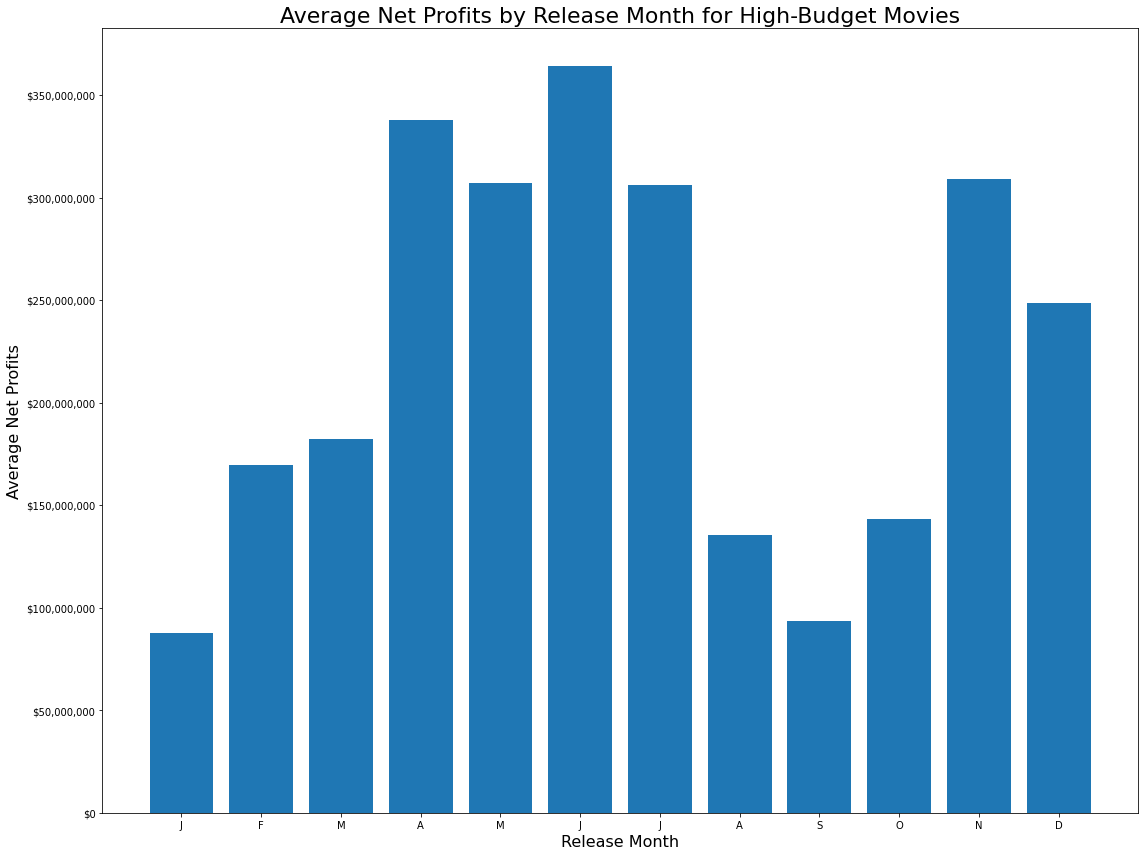

In [154]:
# Show the best month to release high budget movies based on Average Net Profits

high_monthly = high_df.groupby('release_month')['net_profit'].mean()

x=high_monthly.index
height=high_monthly.values

fig, ax = plt.subplots(figsize=(16, 12))

ax.bar(x, height)
ax.set_title("Average Net Profits by Release Month for High-Budget Movies", fontsize=22)
ax.set_ylabel("Average Net Profits", fontsize=16)
ax.set_xlabel("Release Month", fontsize=16)
ax.set_xticks(range(1,13))
ax.set_xticklabels(list('JFMAMJJASOND'));
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

plt.tight_layout()


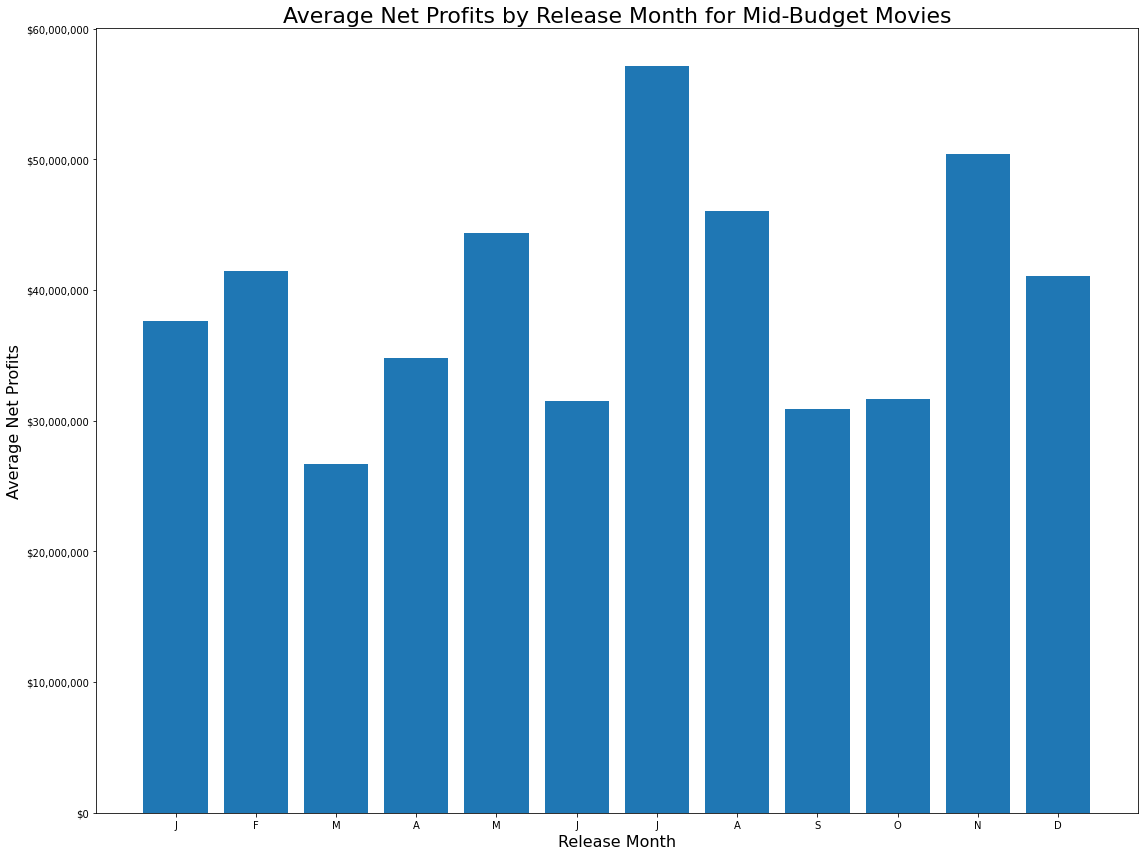

In [155]:
# Show the best month to release mid budget movies based on Average Net Profits

mid_monthly = mid_df.groupby('release_month')['net_profit'].mean()

x=mid_monthly.index
height=mid_monthly.values

fig, ax = plt.subplots(figsize=(16, 12))

ax.bar(x, height)
ax.set_title("Average Net Profits by Release Month for Mid-Budget Movies", fontsize=22)
ax.set_ylabel("Average Net Profits", fontsize=16)
ax.set_xlabel("Release Month", fontsize=16)
ax.set_xticks(range(1,13))
ax.set_xticklabels(list('JFMAMJJASOND'));
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

plt.tight_layout()

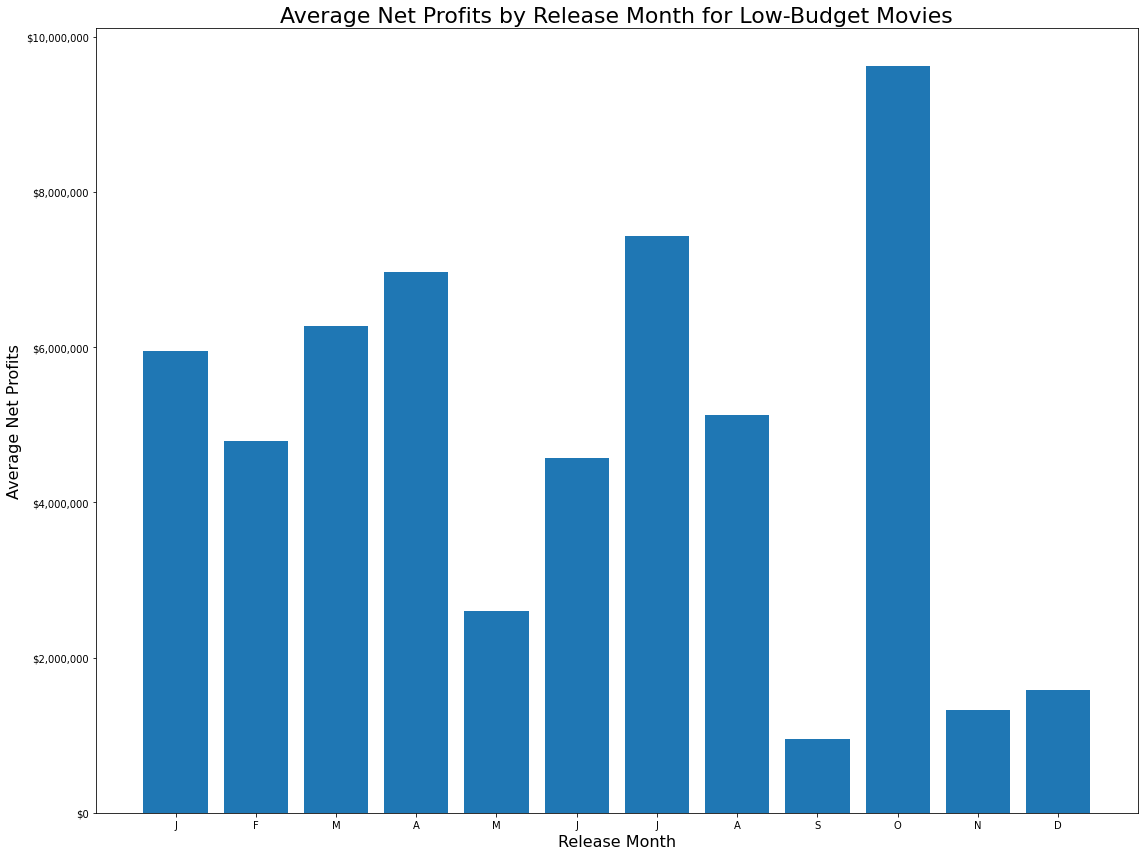

In [156]:
# Show the best month to release low budget movies based on Average Net Profits

low_monthly = low_df.groupby('release_month')['net_profit'].mean()

x=low_monthly.index
height=low_monthly.values

fig, ax = plt.subplots(figsize=(16, 12))

ax.bar(x, height)
ax.set_title("Average Net Profits by Release Month for Low-Budget Movies", fontsize=22)
ax.set_ylabel("Average Net Profits", fontsize=16)
ax.set_xlabel("Release Month", fontsize=16)
ax.set_xticks(range(1,13))
ax.set_xticklabels(list('JFMAMJJASOND'));
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

plt.tight_layout()

In [157]:
# high_df['profit_margin'].sort_values
# high_df.groupby('release_month')['profit_margin'].mean()

high_df.groupby('release_month')['profit_margin'].median()

release_month
1     43.165
2     58.000
3     57.080
4     68.120
5     66.250
6     68.815
7     68.440
8     53.960
9     44.820
10    54.350
11    64.550
12    62.400
Name: profit_margin, dtype: float64

In [158]:
# mid_df['profit_margin'].sort_values
# mid_df.groupby('release_month')['profit_margin'].mean()

mid_df.groupby('release_month')['profit_margin'].median()

release_month
1     57.71
2     47.60
3     38.24
4     41.08
5     43.29
6     38.73
7     58.41
8     57.25
9     33.87
10    12.91
11    56.15
12    44.61
Name: profit_margin, dtype: float64

In [159]:
# low_df['profit_margin'].sort_values
# low_df.groupby('release_month')['profit_margin'].mean()

low_df.groupby('release_month')['profit_margin'].median()

release_month
1       -1290.575
2        -611.910
3       -4984.095
4        -122.030
5        -437.730
6        -799.850
7         -12.060
8         -51.165
9        -401.450
10       -227.980
11       -335.980
12   -1924450.795
Name: profit_margin, dtype: float64

In [160]:
high_df[high_df['Horror'] ==1].groupby('release_month')['profit_margin'].median()

release_month
1     56.350
2     -5.160
3     42.530
5     44.870
6     57.580
7     48.115
8     56.755
9     44.820
10    63.500
12    50.520
Name: profit_margin, dtype: float64

### **Profit Margin Analysis**

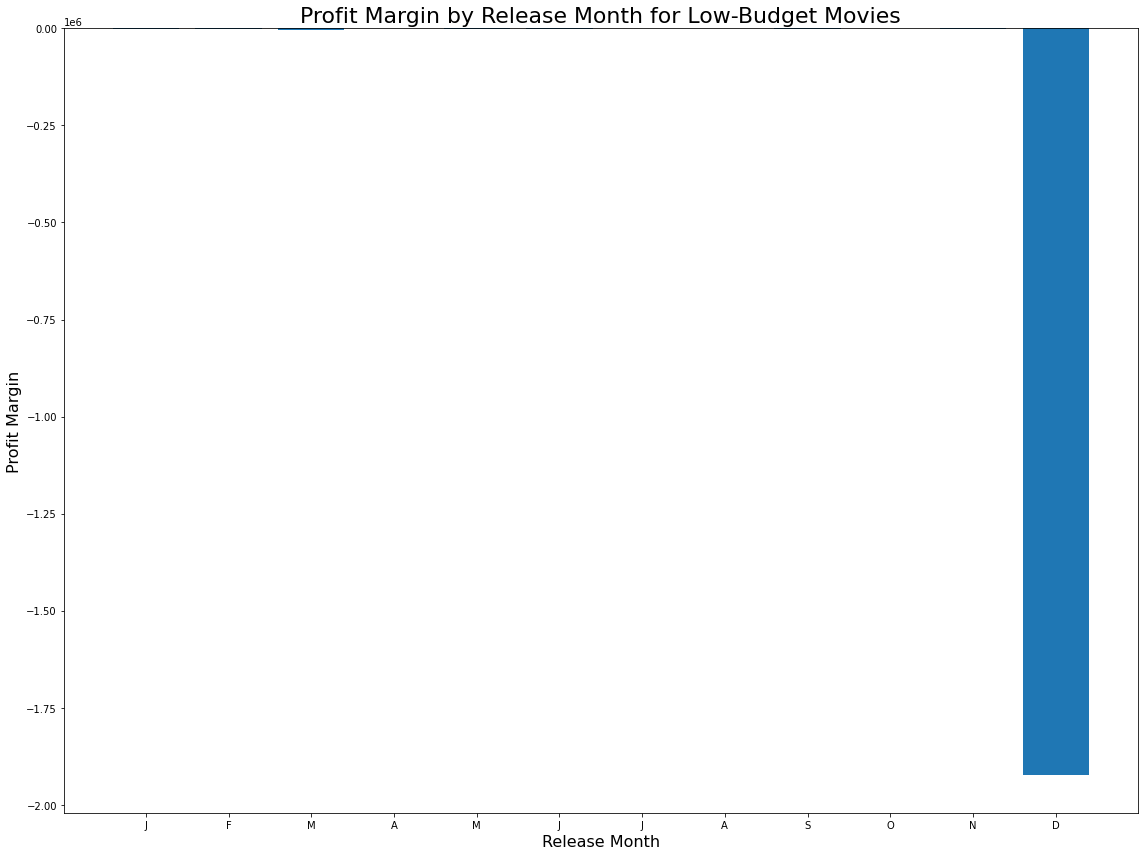

In [161]:
# Show the best month to release low budget movies based on Average Net Profits

low_monthly = low_df.groupby('release_month')['profit_margin'].median()

x=low_monthly.index
height=low_monthly.values

fig, ax = plt.subplots(figsize=(16, 12))

ax.bar(x, height)
ax.set_title("Profit Margin by Release Month for Low-Budget Movies", fontsize=22)
ax.set_ylabel("Profit Margin", fontsize=16)
ax.set_xlabel("Release Month", fontsize=16)
ax.set_xticks(range(1,13))
ax.set_xticklabels(list('JFMAMJJASOND'));
# ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

plt.tight_layout()

### **Importing Final Master Dataset**

In [162]:
movie_data = pd.read_csv('../data/movie_data.csv')
movie_data

,movie,genres,main_genre,subgenres,release_month,release_year,budget,production_budget,domestic_gross,foreign_gross,worldwide_gross,total_profit,ROI
0,Foodfight!,"Action,Animation,Comedy",Action,"['Animation', 'Comedy']",12,2012,mid,45000000,0,73706,73706,-44926294,0.163791
1,The Secret Life of Walter Mitty,"Adventure,Comedy,Drama",Adventure,"['Comedy', 'Drama']",12,2013,high,91000000,58236838,129624345,187861183,96861183,206.440860
2,A Walk Among the Tombstones,"Action,Crime,Drama",Action,"['Crime', 'Drama']",9,2014,mid,28000000,26017685,36090902,62108587,34108587,221.816382
3,Jurassic World,"Action,Adventure,Sci-Fi",Action,"['Adventure', 'Sci-Fi']",6,2015,high,215000000,652270625,996584239,1648854864,1433854864,766.909239
4,The Rum Diary,"Comedy,Drama",Comedy,['Drama'],10,2011,mid,45000000,13109815,8434917,21544732,-23455268,47.877182
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1582,The First Time,Drama,Drama,[],10,2012,low,2000000,17061,0,17061,-1982939,0.853050
1583,Sisters,"Action,Drama",Action,['Drama'],12,2015,mid,30000000,87044645,18986015,106030660,76030660,353.435533
1584,The Promise,Drama,Drama,[],4,2017,high,90000000,8224288,2327129,10551417,-79448583,11.723797
1585,Columbus,Comedy,Comedy,[],8,2017,low,700000,1017107,93404,1110511,410511,158.644429


In [163]:
movie_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1587 entries, 0 to 1586
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   movie              1587 non-null   object 
 1   genres             1587 non-null   object 
 2   main_genre         1587 non-null   object 
 3   subgenres          1587 non-null   object 
 4   release_month      1587 non-null   int64  
 5   release_year       1587 non-null   int64  
 6   budget             1587 non-null   object 
 7   production_budget  1587 non-null   int64  
 8   domestic_gross     1587 non-null   int64  
 9   foreign_gross      1587 non-null   int64  
 10  worldwide_gross    1587 non-null   int64  
 11  total_profit       1587 non-null   int64  
 12  ROI                1587 non-null   float64
dtypes: float64(1), int64(7), object(5)
memory usage: 161.3+ KB


In [164]:
movie_data.describe()

,release_month,release_year,production_budget,domestic_gross,foreign_gross,worldwide_gross,total_profit,ROI
count,1587.000000,1587.000000,1.587000e+03,1.587000e+03,1.587000e+03,1.587000e+03,1.587000e+03,1587.000000
mean,6.783239,2013.903592,4.289525e+07,5.348974e+07,8.083751e+07,1.343273e+08,9.143200e+07,378.714116
std,3.428741,2.555592,5.476229e+07,8.271072e+07,1.519493e+08,2.276758e+08,1.877911e+08,1201.356195
min,1.000000,2010.000000,9.000000e+03,0.000000e+00,0.000000e+00,2.600000e+01,-2.002376e+08,0.002600
25%,4.000000,2012.000000,8.000000e+06,2.826730e+06,1.805454e+06,7.682387e+06,-9.965520e+05,75.986010
50%,7.000000,2014.000000,2.200000e+07,2.512499e+07,1.906292e+07,4.673473e+07,2.086125e+07,208.323185
75%,10.000000,2016.000000,5.000000e+07,6.415727e+07,8.073556e+07,1.497397e+08,9.634678e+07,400.817445
max,12.000000,2019.000000,4.106000e+08,7.000596e+08,1.369319e+09,2.048134e+09,1.748134e+09,41656.474000


In [165]:
high_budget = movie_data[movie_data['budget'].str.contains('high')]
mid_budget = movie_data[movie_data['budget'].str.contains('mid')]
low_budget = movie_data[movie_data['budget'].str.contains('low')]

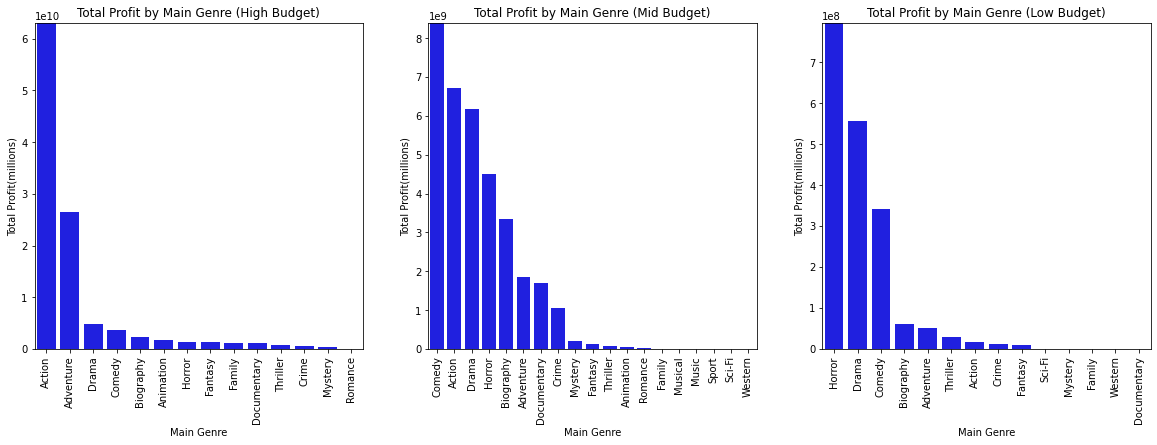

In [166]:
# group movie_data by main_genre and calculate the total profit for each genre
genre_profit_high = high_budget.groupby('main_genre')['total_profit'].sum().reset_index()
genre_profit_mid = mid_budget.groupby('main_genre')['total_profit'].sum().reset_index()
genre_profit_low = low_budget.groupby('main_genre')['total_profit'].sum().reset_index()

# sort the dataframes by total_profit in descending order
genre_profit_high = genre_profit_high.sort_values(by='total_profit', ascending=False)
genre_profit_mid = genre_profit_mid.sort_values(by='total_profit', ascending=False)
genre_profit_low = genre_profit_low.sort_values(by='total_profit', ascending=False)

# create a matrix plot
fig, axs = plt.subplots(1, 3, figsize=(20, 6))

# plot the bar charts
sns.barplot(x='main_genre', y='total_profit', data=genre_profit_high, order=genre_profit_high['main_genre'], color='b', ax=axs[0])
sns.barplot(x='main_genre', y='total_profit', data=genre_profit_mid, order=genre_profit_mid['main_genre'], color='b', ax=axs[1])
sns.barplot(x='main_genre', y='total_profit', data=genre_profit_low, order=genre_profit_low['main_genre'], color='b', ax=axs[2])

# set titles and labels
axs[0].set_title('Total Profit by Main Genre (High Budget)')
axs[1].set_title('Total Profit by Main Genre (Mid Budget)')
axs[2].set_title('Total Profit by Main Genre (Low Budget)')
axs[0].set_xlabel('Main Genre')
axs[1].set_xlabel('Main Genre')
axs[2].set_xlabel('Main Genre')
axs[0].set_ylabel('Total Profit(millions)')
axs[1].set_ylabel('Total Profit(millions)')
axs[2].set_ylabel('Total Profit(millions)')
axs[0].tick_params(axis='x', labelrotation=90)
axs[1].tick_params(axis='x', labelrotation=90)
axs[2].tick_params(axis='x', labelrotation=90)
axs[0].set_ylim([0, max(genre_profit_high['total_profit'])])
axs[1].set_ylim([0, max(genre_profit_mid['total_profit'])])
axs[2].set_ylim([0, max(genre_profit_low['total_profit'])])

plt.show()

### **Regression Analysis**

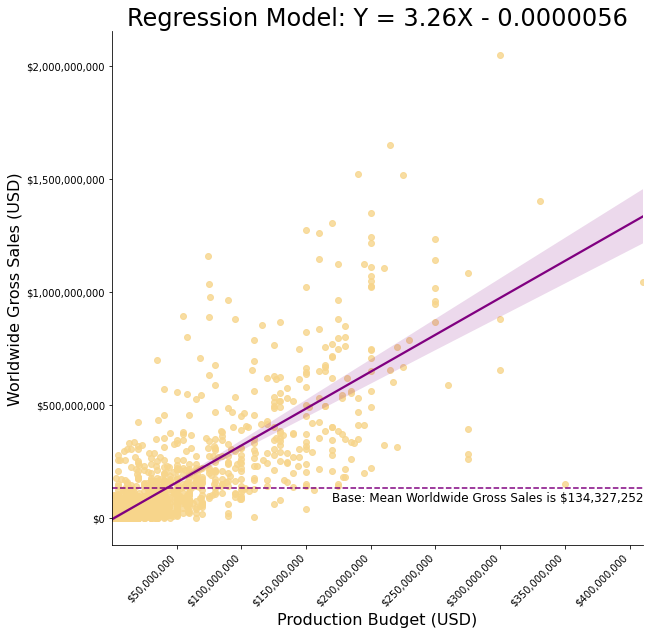

In [167]:

# Plot the scatterplot
lm = sns.lmplot(x='production_budget', y='worldwide_gross', data=movie_data, height=8, aspect=1, scatter_kws= {'color': '#f7d58b'}, line_kws={'color': 'purple'})
  
ax = lm.ax

# Set label for x-axis
ax.set_xlabel( "Production Budget (USD)" , size = 16 )
  
# Set label for y-axis
ax.set_ylabel( "Worldwide Gross Sales (USD)" , size = 16 )
  
# Set title for plot
ax.set_title( "Regression Model: Y = 3.26X - 0.0000056" , size = 24 )

# Rotate the x-tick labels
ax.set_xticklabels(x, rotation=45, ha='right')

# Add a base model that predicts the worldwide gross sales from the mean
xmin, xmax = plt.xlim()

plt.hlines(y=movie_data['worldwide_gross'].mean(),
           xmin=xmin, xmax=xmax,
           colors=['purple'],
           linestyles={'dashed'})
plt.text(xmax, movie_data['worldwide_gross'].mean()-15000000, 
         f'Base: Mean Worldwide Gross Sales is ${movie_data["worldwide_gross"].mean():,.0f}', 
         fontsize=12, ha='right', va='top')

# Format the x- and y-axis labels
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))
  
# Display figure
plt.show()

In [168]:
X = movie_data['production_budget'].values
print(X.shape)

y = movie_data.worldwide_gross.values
print(y.shape)

(1587,)
(1587,)


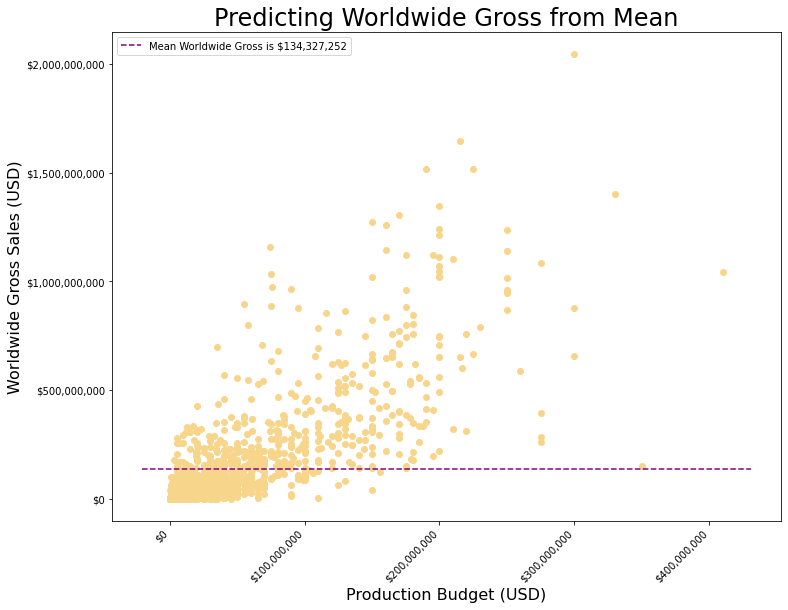

In [169]:
# Baseline model -- use the mean of y as a baseline 

fig, ax = plt.subplots(figsize=(12, 9))

# plt.scatter(movie_data['production_budget'], movie_data['worldwide_gross'])

ax.scatter(movie_data['production_budget'], movie_data['worldwide_gross'], color='#f7d58b')

xmin, xmax = plt.xlim()

plt.hlines(y=movie_data['worldwide_gross'].mean(),
           xmin=xmin, xmax=xmax,
           colors=['purple'],
           linestyles={'dashed'},
           label=f'Mean Worldwide Gross is ${movie_data["worldwide_gross"].mean():,.0f}')

# plt.title('Predicting Worldwide Gross from Mean')

# # Set label for x-axis
ax.set_xlabel( "Production Budget (USD)" , size = 16 )

# # Set label for y-axis
ax.set_ylabel( "Worldwide Gross Sales (USD)" , size = 16 )
  
# # Set title for plot
ax.set_title( "Predicting Worldwide Gross from Mean" , size = 24 )

ax.set_xticklabels(x, rotation=45, ha='right')

ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('${x:,.0f}'))

plt.legend()
plt.show()

In [170]:
model = sm.OLS(y, X, hasconst=False) # creating our model

In [171]:
results = model.fit() # actually fitting the model
results.params # seeing our coefficients

array([3.21285847])

In [172]:
results.predict([0, 2, 4]) # predicting for some random possible X values

array([ 0.        ,  6.42571693, 12.85143386])

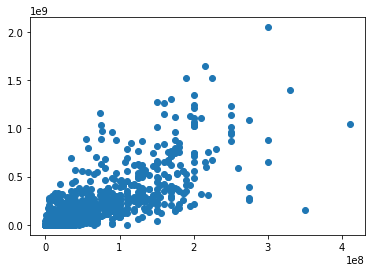

In [173]:
plt.scatter(movie_data['production_budget'], movie_data['worldwide_gross'])

x_pred_range = np.linspace(0, 4, 4)
plt.plot(x_pred_range, results.predict(x_pred_range))

plt.show()

In [174]:
X_with_const = sm.add_constant(X) # easiest way to add the constant
pd.DataFrame(X_with_const, columns=['ones', 'production_budget']).head() # showing the change

,ones,production_budget
0,1.0,45000000.0
1,1.0,91000000.0
2,1.0,28000000.0
3,1.0,215000000.0
4,1.0,45000000.0


In [175]:
model2 = sm.OLS(y, X_with_const, hasconst=True)
results2 = model2.fit()
results2.params

array([-5.63124836e+06,  3.26279701e+00])

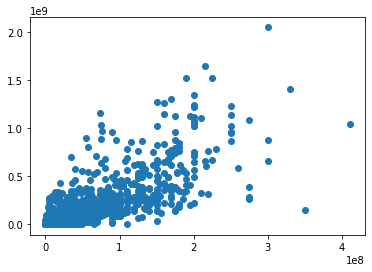

In [176]:
plt.scatter(movie_data['production_budget'], movie_data['worldwide_gross'])

x_pred_range = np.linspace(0, 4, 4)
plt.plot(x_pred_range, results2.predict(sm.add_constant(x_pred_range)))

plt.show()

In [177]:
# Summary of regression results for model with a constant

results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.616
Model:                            OLS   Adj. R-squared:                  0.616
Method:                 Least Squares   F-statistic:                     2542.
Date:                Sun, 25 Jun 2023   Prob (F-statistic):               0.00
Time:                        14:45:45   Log-Likelihood:                -32031.
No. Observations:                1587   AIC:                         6.407e+04
Df Residuals:                    1585   BIC:                         6.408e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -5.631e+06    4.5e+06     -1.251      0.211   -1.45e+07     3.2e+06
x1             3.2628      0.065     50.414      0.000       3.136       3.390
==============================================================================
Omnibus:                      780.042   Durbin-Watson:                   1.950
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            12952.413
Skew:                           1.882   Prob(JB):                         0.00
Kurtosis:                      16.480   Cond. No.                     8.84e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 8.84e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""